In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append('..')
sys.path.append('../../')
sys.path.append('../data_processing/')
sys.path.append('../model/')
sys.path.append('../model/utils/')
sys.path.append('../model/EGNN_backbone')

In [3]:
import numpy as np
from torch_geometric.loader import DataLoader
import torch
import torch.nn.functional as F
from omegaconf import OmegaConf
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdForceFieldHelpers import UFFOptimizeMolecule
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib
import matplotlib.pylab as plt

In [4]:
%matplotlib inline

In [5]:
from data_processing.paired_data import PharmacophoreDataset, CombinedGraphDataset, CombinedSparseGraphDataset
from data_processing.reconstruction import get_atomic_number_from_index, is_aromatic_from_index, reconstruct_from_generated
from data_processing.utils import MAP_ATOMIC_NUMBER_TO_INDEX

In [6]:
from model.pp_bridge import PPBridge
from model.pp_bridge_sampler import PPBridgeSampler
from model.utils.utils_diffusion import center2zero_combined_graph, center2zero_with_mask, center2zero

In [7]:
from script_utils import load_data
from evaluation.utils_eval import build_pdb_dict

In [8]:
# init with fixed points
# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-05-30_23_27_53.688104' # only basic
# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-05-31_14_11_45.077216' # support aromatic

# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-14_11_41_42.887999'
# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-13_20_17_47.526432'
# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-13_20_54_21.154940'
# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-15_19_52_36.665811'
# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-16_14_16_52.051160'
# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-17_02_43_18.953513'
# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-17_02_43_52.157052'
# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-19_14_29_28.164795'

# init with standard gaussian noise
# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-06-17_23_06_28.209248' # only basic
# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-06-17_23_04_23.779433' # support aromatic

# CE loss
# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-02_02_43_48.858042' # only basic
# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-02_02_44_27.850031' # support aromatic

# mixed init
# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-20_13_18_46.225022'

# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-30_02_43_56.802640'
# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-30_02_43_19.450576'

# init with pp center + non-pp cluster center
# model_root = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-31_22_41_26.883181'
# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-31_22_40_53.679692'

model_root = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-08-19_21_05_04.140916'
# model_root = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-08-19_13_30_50.133260'

# model_root = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-09-09_19_32_22.958819'
# model_root = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-09-09_19_31_24.729978'
# model_root = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-09-11_10_44_52.084507'

# model_root = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-09-12_21_58_45.966574'
# model_root = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-09-12_13_35_57.272142'
# model_root = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-09-13_22_01_00.857291'

# model_root = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-09-13_00_11_53.290194'

# model_root = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-09-16_23_26_48.397414'

# model_root = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-09-17_22_14_07.838736'

# uncond (these two should be the same)
# model_root = '../lightning_logs/uncond_vp_bridge_egnn_CombinedUnconditionalDataset_2024-09-05_00_09_16.277074'
# model_root = '../lightning_logs/uncond_vp_bridge_egnn_CombinedUnconditionalDataset_2024-09-10_14_52_18.964537'

basic_mode = False

In [9]:
config_file = os.path.join(model_root, 'vp_bridge_egnn.yml')
# config_file = os.path.join(model_root, 'uncond_vp_bridge_egnn.yml')
# config_file = '../../src/config/vp_bridge_egnn.yml'
config = OmegaConf.load(config_file)
# config.data.aromatic = True
config

{'model': {'denoiser': {'bridge_type': 'vp', 'beta_d': 2, 'beta_min': 0.1, 'schedule_sampler': 'real-uniform', 'use_ema': True, 'ema_decay': 0.999, 'weight_decay': 1e-12, 'weight_schedule': 'bridge_karras', 'loss_x_weight': 10.0}, 'backbone': {'type': 'EGNN', 'feature_size': 12, 'num_layers': 10, 'hidden_size': 128, 'time_cond': True, 'xT_type': 'pp', 'xT_mode': 'concat_graph'}}, 'training': {'batch_size': 200, 'log_interval': 100, 'save_interval': 1000, 'test_interval': 1000, 'total_training_steps': 10000000, 'learning_rate': 0.01, 'lr_anneal_steps': 0, 'max_epochs': 1000, 'use_lr_scheduler': True, 'lr_scheduler_config': {'target': 'model.utils.lr_scheduler.LambdaLinearScheduler', 'params': {'warm_up_steps': [10000], 'cycle_lengths': [10000000000000], 'f_start': [1e-06], 'f_max': [1.0], 'f_min': [1.0]}}}, 'sampling': {'batch_size': 2000}, 'data': {'root': '../data/cleaned_crossdocked_data', 'max_node_num': 86, 'coord_dim': 3, 'module': 'CombinedSparseGraphDataset', 'aromatic': True, '

In [10]:
# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-05-30_23_27_53.688104/epoch=94-val_loss=2.98.ckpt'
# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-05-31_14_11_45.077216/epoch=98-val_loss=3.15.ckpt'

# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-06-17_23_04_23.779433/epoch=85-val_loss=4.38.ckpt'
# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-06-17_23_06_28.209248/epoch=82-val_loss=4.18.ckpt'

# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-02_02_43_48.858042/epoch=89-val_loss=16.68.ckpt'
# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-02_02_44_27.850031/epoch=72-val_loss=19.98.ckpt'

# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-14_11_41_42.887999/epoch=65-val_loss=2.52.ckpt'
# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-13_20_17_47.526432/epoch=66-val_loss=2.63.ckpt'
# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-13_20_54_21.154940/epoch=97-val_loss=10.04.ckpt'
# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-15_19_52_36.665811/epoch=91-val_loss=143.19.ckpt'
# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-16_14_16_52.051160/epoch=95-val_loss=37.01.ckpt'
# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-17_02_43_18.953513/epoch=78-val_loss=132.14.ckpt'
# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-17_02_43_52.157052/epoch=71-val_loss=132.93.ckpt'
# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-19_14_29_28.164795/epoch=146-val_loss=141.51.ckpt'

# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-20_13_18_46.225022/epoch=65-val_loss=138.19.ckpt'

# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-30_02_43_56.802640/epoch=119-val_loss=189.31.ckpt'
# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-30_02_43_19.450576/epoch=107-val_loss=187.44.ckpt'

# ckpt_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-31_22_41_26.883181/epoch=150-val_loss=83.18.ckpt'
# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-31_22_40_53.679692/epoch=43-val_loss=89.12.ckpt'

ckpt_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-08-19_21_05_04.140916/epoch=166-val_loss=75.36.ckpt'
# ckpt_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-08-19_13_30_50.133260/epoch=74-val_loss=77.26.ckpt'

# ckpt_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-09-09_19_32_22.958819/epoch=168-val_loss=41.14.ckpt'
# ckpt_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-09-09_19_31_24.729978/epoch=118-val_loss=45.61.ckpt'
# ckpt_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-09-11_10_44_52.084507/epoch=107-val_loss=43.58.ckpt'

# ckpt_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-09-12_21_58_45.966574/epoch=31-val_loss=198.19.ckpt'
# ckpt_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-09-12_13_35_57.272142/epoch=81-val_loss=102.42.ckpt'
# ckpt_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-09-13_22_01_00.857291/epoch=103-val_loss=176.03.ckpt'

# ckpt_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-09-13_00_11_53.290194/epoch=317-val_loss=146.51.ckpt'

# ckpt_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-09-16_23_26_48.397414/epoch=129-val_loss=1340.61.ckpt'

# ckpt_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-09-17_22_14_07.838736/epoch=55-val_loss=120.76.ckpt'

# uncond
# ckpt_path = '../lightning_logs/uncond_vp_bridge_egnn_CombinedUnconditionalDataset_2024-09-05_00_09_16.277074/epoch=65-val_loss=280.25.ckpt'
# ckpt_path = '../lightning_logs/uncond_vp_bridge_egnn_CombinedUnconditionalDataset_2024-09-10_14_52_18.964537/epoch=41-val_loss=287.20.ckpt'

# ckpt = torch.load(ckpt_path)
# ckpt

In [11]:
device = 'cuda:1'

In [12]:
sampler = PPBridgeSampler(config, ckpt_path, device)

Using lr scheduler
Using real uniform sampler
Using lr scheduler
Using real uniform sampler


In [15]:
root = '/home2/conghao001/pharmacophore2drug/PP2Drug/data/cleaned_crossdocked_data'
split = 'test'
batch_size = 10
num_workers = 0

In [16]:
# dataset = CombinedGraphDataset(root, split)
# dataset = CombinedSparseGraphDataset(root, split)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

dataset, _ = load_data(config.data.module, root, split=split, batch_size=batch_size, aromatic=config.data.aromatic)

use processed_HDBSCAN_non_filtered
use processed_HDBSCAN_non_filtered
use processed_HDBSCAN_non_filtered
use processed_HDBSCAN_non_filtered
use processed_HDBSCAN_non_filtered


In [17]:
dataloader = DataLoader(dataset[0:100], batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [18]:
len(dataset)

15235

In [19]:
pdb_dict, pdb_rev_dict = build_pdb_dict(root+'/raw')

In [20]:
one = next(iter(dataloader))
one = one.to(device)
one

DataBatch(x=[562, 12], pos=[562, 3], target_x=[562, 12], target_pos=[562, 3], Gt_mask=[562], ligand_name=[10], batch=[562], ptr=[11])

In [22]:
one.ligand_name

['2z9y_A_rec_2z9y_ddr_lig_tt_min_0',
 '2e3m_A_rec_2e3n_6cm_lig_tt_min_0',
 '3h3r_A_rec_3h3t_16h_lig_tt_min_0',
 '3h3q_A_rec_3h3q_h13_lig_tt_min_0',
 '3h3s_B_rec_3h3t_16h_lig_tt_min_0',
 '2z9z_A_rec_3h3q_h13_lig_tt_docked_17',
 '2z9z_A_rec_3h3r_14h_lig_tt_min_0',
 '3h3r_A_rec_3h3q_h13_lig_tt_min_0',
 '2z9z_A_rec_2z9y_ddr_lig_tt_min_0',
 '3h3q_A_rec_3h3r_14h_lig_tt_min_0']

In [23]:
one.ligand_name.index('3h3q_A_rec_3h3r_14h_lig_tt_min_0')

9

In [19]:
# for batch in dataloader:
#     if batch.ligand_name[0] == '4ls1_A_rec_5h73_7l7_lig_tt_min_0':
#         one = batch
# one = one.to(device)

In [20]:
one.ligand_name

['4jf1_A_rec_4jez_p00_lig_tt_min_0',
 '4jf0_B_rec_4jey_plp_lig_tt_min_0',
 '4jew_A_rec_4jey_plp_lig_tt_min_0',
 '4jew_A_rec_4jf1_plp_lig_tt_docked_0',
 '4jev_A_rec_4jez_p00_lig_tt_docked_1',
 '4jey_A_rec_4jey_plp_lig_tt_docked_0',
 '2pb2_B_rec_4jey_plp_lig_tt_min_0',
 '4jew_A_rec_4jey_plp_lig_tt_docked_0',
 '4jev_A_rec_4jew_p00_lig_tt_docked_0',
 '4jew_A_rec_4jew_p00_lig_tt_min_0']

In [21]:
# tmp_mask = one.Gt_mask.view(batch_size, -1)
# one.target_x[0][tmp_mask[0]].size()

In [22]:
# for node_feat in one.target_x[one.Gt_mask]:
#     print(node_feat)

In [23]:
num_nodes = one.x.size(0)
node_mask = torch.ones([1, num_nodes], device=one.x.device, dtype=torch.bool)

In [24]:
xT, hT, Gt_mask, batch_info = sampler.preprocess(one.target_pos, one.target_x, node_mask=node_mask, Gt_mask=one.Gt_mask, batch_info=one.batch, device=device)

In [25]:
xT.size()

torch.Size([382, 3])

In [26]:
hT

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:1')

In [27]:
Gt_mask.size()

torch.Size([382])

## Important
***sigma min and max values***
differ for ve/vp bridges!!!

In [47]:
steps = 200
# x, x_traj, h, h_traj, nfe = sampler.sample(one.target_pos, one.target_x, steps, node_mask=one.node_mask, Gt_mask=one.Gt_mask, batch_info=one.batch, churn_step_ratio=0.33, device=device)
x, x_traj, h, h_traj, nfe = sampler.sample(one.target_pos, one.target_x, steps, node_mask=node_mask, Gt_mask=one.Gt_mask, batch_info=one.batch, sigma_min=0.001, sigma_max=1, churn_step_ratio=0.001, device=device)

nfe: 599


In [48]:
# print(x.size(), x[Gt_mask].size())

In [49]:
# one.batch.size()

In [50]:
num_graphs = max(one.batch).item() + 1
num_graphs

10

In [51]:
i = 0
index_i = one.batch==i
index_i.sum()

tensor(48, device='cuda:1')

In [52]:
# x_i = x[Gt_mask][index_i]
x_i = x[index_i][Gt_mask[index_i]]
x_i.size()

torch.Size([24, 3])

In [53]:
x_traj_i = [xt[index_i.cpu()][Gt_mask[index_i].cpu()] for xt in x_traj]
x_traj_i

[tensor([[-2.5244, -1.0689,  1.6462],
         [-2.5195, -1.0725,  1.6356],
         [-2.5284, -1.0831,  1.6441],
         [-2.5085, -1.0695,  1.6281],
         [-3.3394, -0.9744,  4.3758],
         [-2.5057, -1.0695,  1.6347],
         [-0.6289, -0.6092,  3.6179],
         [-2.5157, -1.0544,  1.6165],
         [ 0.2105, -0.6638,  0.8064],
         [ 1.0524,  0.0746,  1.4475],
         [ 2.3519,  0.2316,  1.0063],
         [ 3.0870,  1.4118,  1.2986],
         [ 2.4048,  2.6447,  0.6779],
         [ 2.8639,  2.0214, -1.0707],
         [ 2.8527,  2.0396, -1.0595],
         [ 2.8714,  4.4342, -1.7493],
         [ 2.8897,  4.3932, -1.7425],
         [ 2.8752,  4.4101, -1.7688],
         [-1.8713, -1.1884, -1.2111],
         [-0.4997, -2.3506, -2.8977],
         [-0.5052, -2.3752, -2.8711],
         [-0.5009, -2.3625, -2.8814],
         [-0.5057, -2.3541, -2.8955],
         [-0.5063, -2.3653, -2.8880]], device='cuda:1'),
 tensor([[-2.5309, -1.0612,  1.6569],
         [-2.5111, -1.0774,  1.

In [54]:
# len(x_traj_i)

In [55]:
# len(x_traj)

In [56]:
# x_traj_i[0].size()

In [57]:
# x_traj[0].size()

In [58]:
# x_i

In [59]:
x_i_arr = x_i.cpu().numpy()

x_i_arr[:, 0]

array([-0.4098484 ,  0.1192313 ,  0.06574347,  0.6008749 , -0.7627528 ,
        0.46917772,  0.48230398, -0.6842896 , -0.1791496 , -0.49778003,
        1.2458793 ,  0.40026575, -0.2198706 ,  0.8664104 ,  0.04805481,
        0.9715465 , -0.13246262,  0.48593816, -0.53422976,  0.28620872,
       -0.37200394, -0.5203939 , -0.6581221 ,  0.18461053], dtype=float32)

In [60]:
fig = go.Figure(data=[go.Scatter3d(x=x_i_arr[:, 0], y=x_i_arr[:, 1], z=x_i_arr[:, 2],
                                   mode='markers')])
fig.show()

In [61]:
xt_sampled = [x_traj_i[i] for i in range(len(x_traj_i)) if i%80==0]
len(xt_sampled)

6

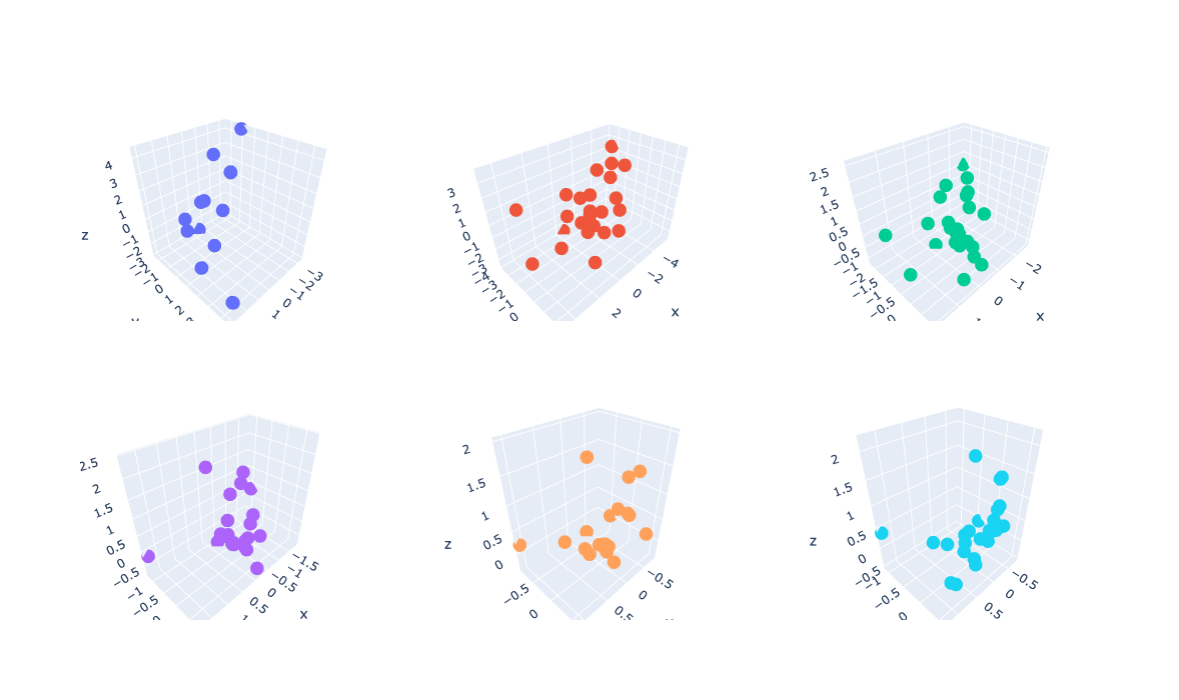

In [62]:
nc = 3
nr = len(xt_sampled)//nc #+ 1
fig = make_subplots(rows=nr, cols=nc, 
                   specs = [[{"type": "scatter3d"} for i in range(nc)] for i in range(nr)]
                   )

for i in range(len(xt_sampled)):
    arr = xt_sampled[i].cpu().numpy()
    fig.add_trace(
        go.Scatter3d(x=arr[:, 0], y=arr[:, 1], z=arr[:, 2], mode='markers'),
        row=i//nc + 1, col=i%nc + 1
    )

fig.update_layout(height=nr*350, showlegend=False)
fig.show()

In [63]:
# one.original_pos
original_pos_i = one.pos[index_i][Gt_mask[index_i]]
original_pos_0center_i = center2zero(original_pos_i)
original_pos_0center_i.size()

torch.Size([24, 3])

In [64]:
original_pos_0center_i_arr = original_pos_0center_i.cpu().numpy()

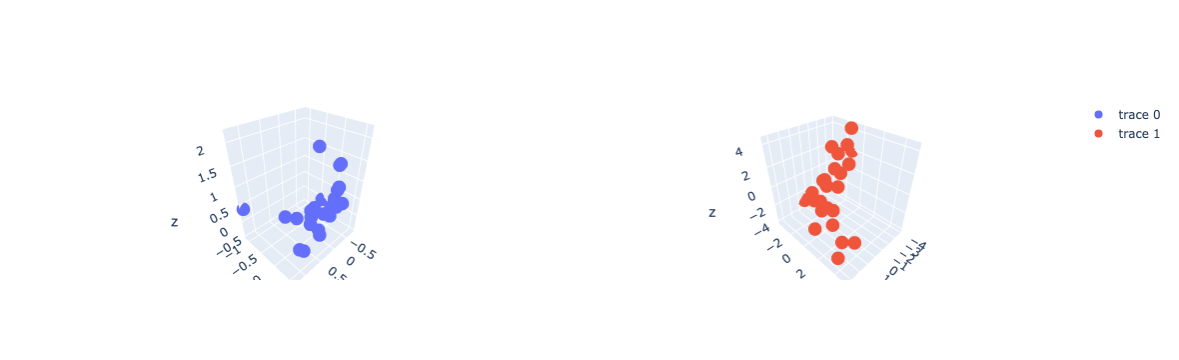

In [65]:
fig = make_subplots(rows=1, cols=2, 
                   specs = [[{"type": "scatter3d"} for i in range(2)]]
                   )


fig.add_trace(
    go.Scatter3d(x=x_i_arr[:, 0], y=x_i_arr[:, 1], z=x_i_arr[:, 2], mode='markers'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter3d(x=original_pos_0center_i_arr[:, 0], y=original_pos_0center_i_arr[:, 1], z=original_pos_0center_i_arr[:, 2], mode='markers'),
    row=1, col=2
)

# fig.update_layout(height=500, showlegend=False)
fig.show()

In [606]:
h_i = h[index_i][Gt_mask[index_i]]
h_i.size()

torch.Size([24, 12])

In [607]:
# h_i

In [608]:
h_traj_i = [xt[index_i.cpu()][Gt_mask[index_i].cpu()] for xt in x_traj]

In [609]:
# torch.argmax(one.x[i], dim=-1)
# torch.argmax(one.x, dim=-1)

In [610]:
# h = F.softmax(h, dim=-1)
h_class = torch.argmax(h_i, dim=-1)
h_class

tensor([1, 1, 4, 1, 1, 1, 1, 4, 1, 1, 4, 0, 1, 0, 0, 0, 0, 4, 3, 4, 4, 0, 4, 4],
       device='cuda:2')

In [611]:
h_onehot = torch.nn.functional.one_hot(h_class, num_classes=13)
h_onehot

tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0,

In [612]:
atom_index = h_class.detach().cpu()
if h_onehot.size(-1) == 8:
    index_to_atom_type = MAP_ATOMIC_NUMBER_TO_INDEX
    atom_type = get_atomic_number_from_index(atom_index, index_to_atom_type=index_to_atom_type_aromatic)
else:
    atom_type = get_atomic_number_from_index(atom_index)
atom_type

[6, 6, 8, 6, 6, 6, 6, 8, 6, 6, 8, 6, 6, 6, 6, 6, 6, 8, 7, 8, 8, 6, 8, 8]

In [613]:
if basic_mode:
    atom_aromatic = None
else:
    atom_aromatic = is_aromatic_from_index(atom_index)
atom_aromatic

[True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False]

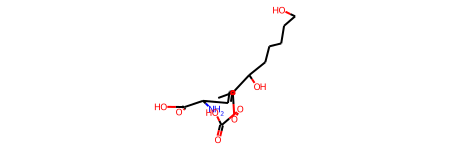

In [614]:
pos = x_i.detach().cpu().tolist()
mol = reconstruct_from_generated(pos, atom_type, atom_aromatic, basic_mode)
mol

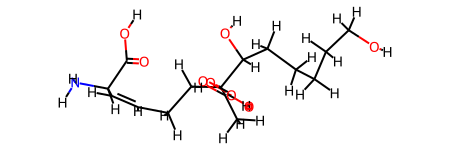

In [615]:
mol = Chem.AddHs(mol, addCoords=True)
AllChem.EmbedMolecule(mol)
UFFOptimizeMolecule(mol)
mol

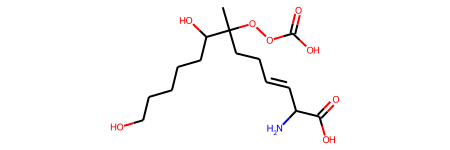

In [616]:
Chem.MolFromSmiles(Chem.MolToSmiles(mol))

In [617]:
# this is for aromatic!!! not basic mode!!!

mols = []
for i in range(num_graphs):
    index_i = one.batch==i
    x_i = x[index_i][Gt_mask[index_i]]
    h_i = h[index_i][Gt_mask[index_i]]
    h_class = torch.argmax(h_i, dim=-1)
    atom_index = h_class.detach().cpu()
    if basic_mode: 
        # there are actually two conditions in basic mode: one is the data already have no aromatic information (feat_size=8), the other is we dont consider aromaticity
        if x_i.size(-1) == 8:
            index_to_atom_type = MAP_ATOMIC_NUMBER_TO_INDEX
            atom_type = get_atomic_number_from_index(atom_index, index_to_atom_type=index_to_atom_type)
            atom_aromatic = None

        # consider when we have aromaticity in the data but we dont want to consider it 
        else:
            atom_type = get_atomic_number_from_index(atom_index)
            atom_aromatic = None
    else:
        atom_type = get_atomic_number_from_index(atom_index)
        atom_aromatic = is_aromatic_from_index(atom_index)
    pos = x_i.detach().cpu().tolist()
    try:
        mol = reconstruct_from_generated(pos, atom_type, atom_aromatic, basic_mode)
        mols.append(mol)
    except:
        continue

[13:06:36] Explicit valence for atom # 23 O, 3, is greater than permitted


In [618]:
len(mols)

9

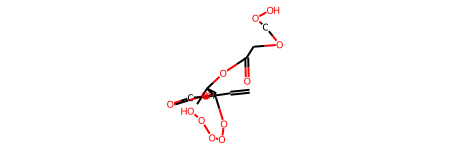

In [654]:
example = mols[8]
example

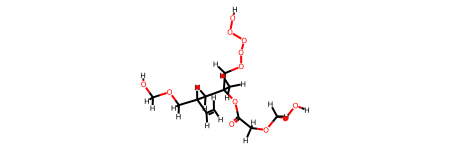

In [655]:
example = Chem.AddHs(example, addCoords=True)
AllChem.EmbedMolecule(example)
UFFOptimizeMolecule(example)
example

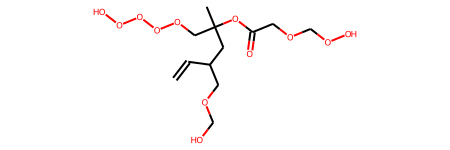

In [656]:
m = Chem.MolFromSmiles(Chem.MolToSmiles(example))
m

In [644]:
# with Chem.SDWriter('generated_example.sdf') as w:
#   w.write(m)